### Demo Dashboards Notebooks
* Use this notebook to monitor the training runs kicked off from the Unity Demo File Notebook
* But, do not run this notebook from the same virtual environment where the ml-agents demo training run was kicked off
* Create a separate virtual environment to install tensorflow and other libraries in this notebook (do not install ml-agents in that notebook!)

In [1]:
from packaging import version
import tensorflow
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.express as px
from scipy import stats
import tensorboard as tb
import yaml
import subprocess
import os
import struct
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tensorboard.compat.proto import event_pb2

%matplotlib inline

Configuration YAML files
All training hyperparameters, reward configurations, and network architectures are specified within a single, well‑organized YAML file. This file instructs the Python trainer on which algorithm to apply, how many layers the neural network should have, the learning speed to adopt, and the level of persistence to maintain during training.

In [2]:
#functions to get, update, and save yaml config files

def getmlconfig(path):
    file = path
    with open(file, 'r') as file:
        data = yaml.safe_load(file)

    return data

def update_config(config,scene,hyperparameter,data): 
    
    config['behaviors'][scene]['hyperparameters'][hyperparameter] = data
    
    return config

def update_reward_config(reward_config,scene,hyperparameter,data):

    reward_config['behaviors'][scene]['reward_signals']['curiosity'][hyperparameter] = data

    return reward_config
    
    
def save_config(path,config):

    with open(path,'w') as file:
        yaml.dump(config,file, default_flow_style=False)


The default method for monitoring an Unity ML Agent experiment performance is through TensorBoard.
TensorBoard is a visualization tool that allows you to monitor the training progress in real-time, diagnose issues, and determine when convergence (successful learning) has occured

TensorBoard Instructions While training is running, open a separate terminal window and execute the following command from the directory where you ran mlagents-learn:
tensorboard --logdir=results
Then, open your web browser to the url it provides

The following functions enable monitoring of a Unity ML Agent experiment in a jupyter notebook so experiment results can be saved for further analysis.
note: The latest Tensorflow numpy version requirements is not compatible with Unity ML Agents which causes the build to fail. Please launch this notebook using a different virtual environment from the environment in which you are kicking off your experiments. Do not install Tensorflow in the virtual environment in which you run the experiments.

In [3]:
#defining functions to analyze and compare training configurations

def calc_gradient_steps(buffer_size,batch_size):

    return buffer_size/batch_size

def network_optimization(buffer_size,batch_size,num_epochs):

    gs = calc_gradient_steps(buffer_size,batch_size)

    return gs * num_epochs


def exploration_score(beta,epsilon, learning_rate):

    exploration_score = (beta*100) + (epsilon *10) + (learning_rate *1000) #normalize the scores

    return exploration_score



def training_efficiency_metrics(config, scene):
    """
    Complete analysis including exploration/exploitation balance
    """

    buffer_size = config['behaviors'][scene]['hyperparameters']['buffer_size']
    batch_size = config['behaviors'][scene]['hyperparameters']['batch_size']
    num_epochs = config['behaviors'][scene]['hyperparameters']['num_epoch']
    learning_rate = config['behaviors'][scene]['hyperparameters']['learning_rate']
    beta = config['behaviors'][scene]['hyperparameters']['beta']
    epsilon = config['behaviors'][scene]['hyperparameters']['epsilon']

    
    total_updates = network_optimization(buffer_size, batch_size, num_epochs)
       
    # Sample efficiency (how much data before training)
    sample_efficiency = buffer_size / total_updates
    
    # Update frequency (relative to buffer)
    update_intensity = total_updates / buffer_size
    

    
    metrics = {
        'gradient_steps_per_cycle': calc_gradient_steps(buffer_size,batch_size),
        'total_updates': total_updates,
        'sample_efficiency': round(sample_efficiency,3),
        'update_intensity': round(update_intensity,3),
        'exploration_score': exploration_score(beta,epsilon, learning_rate),
        'learning_rate': learning_rate,
        'beta': beta,
        'epsilon': epsilon
    }
    
    return metrics

In [4]:
#returns the experiment metric data (instead of using tensorboard)

def get_metrics(path,scene, experiment_id,metric):
    
      
    # Find events file
    path=path + experiment_id + scene
    log_dir = os.path.expanduser(path)
    event_file = None
    
    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if 'tfevents' in file:
                event_file = os.path.join(root, file)
                break
        if event_file:
            break
    
    if not event_file:
        print(f"No events file found for {experiment_id}")
        return None
  
    data= {'step': [], 'value': []}
    
    with open(event_file, 'rb') as f:
        while True:
            try:
                header = f.read(12) #read header (8 bytes length + 4 bytes CRC) 
                if len(header) < 12: #END OF FILE?
                    break
                
                data_len = struct.unpack('<Q', header[:8])[0] #extract length from first 8 bytes
                event_bytes = f.read(data_len) #read that many bytes of actual data
                if len(event_bytes) < data_len: #safety check that we got all the data that was expected 
                    break
                
                f.read(4)  # reads & ignores the 4 bytes of CRC checksum

                #deserialize binary data into a python object
                event = event_pb2.Event()
                event.ParseFromString(event_bytes)
                
                if event.summary and event.summary.value:
                    for value in event.summary.value:
                        
                        tag = value.tag

                        
                        
                        if tag == metric and value.HasField('simple_value'):
                            data['step'].append(event.step)
                            data['value'].append(value.simple_value)

            except:
                break
    
    # Convert to DataFrame
    if not data['step']:  # Check if we found any data
        print(f"No data found for metric: {metric}")
        return None
        
    df = pd.DataFrame(data) 

        
    return df

In [5]:
 #define metrics

policy_entropy = 'Policy/Entropy' #measures randomness/diversity of the agent's actions (exploration)
episode_length = 'Environment/Episode Length' #tracks how many steps (timesteps) each episode lasts before it ends  (increasing episode length = agent improving)

#policy/extrinsic value is a training health indicator as ideally it should match with the env_cum_reward
value_estimate = 'Policy/Extrinsic Value Estimate' #tracks the agents prediction of how much total future reward it expects to get from the current state
cumulative_reward = 'Environment/Cumulative Reward' #the average total reward the agent achieves per episode; good for overall performance
policy_reward = 'Policy/Extrinsic Reward' #average reward used for policy updates...this is the reward signal used for training the policy

policy_loss = 'Losses/Policy Loss' #measures the change in the agent's policy (the Actor)
value_loss = 'Losses/Value Loss' #measures the accuracy of the critic network (the value estimator)

policy_lr = 'Policy/Learning Rate' #tracks how fast the neural network's weights are being updated during training
#high learning rate means big updates, learn fast (but might be unstable)
#low learning rate means small updates, learns slower (but more stable)

#how much the policy can change per update (training stability). how much shoul di let the policy change this update?
pol_epsilon = 'Policy/Epsilon' #returns the current value of epsilon at that training step, which changes over time because of the schedule

policy_beta = 'Policy/Beta' #measures the current value of the beta coefficient at the training step


In [6]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

def metric_analysis(mpath,scene,experiment,metric1,metric2,plot1name,plot2name,title,ytitle):

    df1 = get_metrics(mpath,scene,experiment,metric1)
    df2 = get_metrics(mpath,scene,experiment,metric2)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df1['step'],y=df1['value'],mode='lines+markers',name = plot1name))

    fig.add_trace(go.Scatter(x=df2['step'],y=df2['value'],mode='lines+markers',name = plot2name))

    fig.update_layout(
    title = title,
    xaxis_title = 'Steps',
    yaxis_title = ytitle,
    legend_title = 'Plot Name',
    template = 'plotly_white')

    fig.show()


def exp_metric_analysis(mpath,scene,exp1,exp2,exp3,metric,title,ytitle):

    df1 = get_metrics(mpath,exp1,metric)
    df2 = get_metrics(mpath,exp2,metric)
    df3 = get_metrics(mpath,exp3,metric)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df1['step'],y=df1['value'],mode='lines+markers',name = exp1))

    fig.add_trace(go.Scatter(x=df2['step'],y=df2['value'],mode='lines+markers',name = exp2))

    fig.add_trace(go.Scatter(x=df3['step'],y=df3['value'],mode='lines+markers',name = exp3))

    fig.update_layout(
    title = title,
    xaxis_title = 'Steps',
    yaxis_title = ytitle,
    height = 800,
    width = 1000,
    legend_title = 'Plot Name',
    template = 'plotly_white')

    fig.show()


def norm_metric_analysis(mpath,scene,experiment,metric1,metric2,plot1name,plot2name,title,ytitle):

    df1 = get_metrics(mpath,experiment,metric1)
    val1 = normalize(df1['value'])
    df2 = get_metrics(mpath,experiment,metric2)
    val2 = normalize(df2['value'])
   
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df1['step'],y=val1,mode='lines+markers',name = plot1name))

    fig.add_trace(go.Scatter(x=df2['step'],y=val2,mode='lines+markers',name = plot2name))

    fig.update_layout(
        
    title = title,
    xaxis_title = 'Steps',
    yaxis_title = ytitle,
    legend_title = 'Plot Name',
    template = 'plotly_white')

    fig.show()


def single_chart(mpath,scene,experiment,metric,title,ytitle):

    df = get_metrics(mpath,scene,experiment,metric)

    fig.add_trace(go.Scatter(x=df['step'],y=df['value'],mode='lines+markers'))

    fig.update_layout(
        
    title = title,
    xaxis_title = 'Steps',
    yaxis_title = ytitle,
    legend_title = 'Plot Name',
    template = 'plotly_white')

    fig.show()


def environment_subplots(mpath,scene,experiment):

    reward = get_metrics(mpath,scene,experiment,'Environment/Cumulative Reward')

    length = get_metrics(mpath,scene,experiment,'Environment/Episode Length')

    fig = make_subplots(
        rows=1,cols=2,
        subplot_titles = ('Cumulative Reward','Episode Length')

    )

    fig.add_trace(
        go.Scatter(x=reward['step'],y=reward['value'],
                   mode='lines+markers', name = 'Reward'), row=1,col=1
    )
        
    fig.add_trace(
        go.Scatter(x=length['step'],y=length['value'],
                   mode='lines+markers', name = 'Episode Length'), row=1,col=2
    )

    #update axes labels

    fig.update_xaxes(title_text='Steps', row=1,col=1)
    fig.update_xaxes(title_text='Steps',row=1,col=2)
    fig.update_yaxes(title_text='Reward',row=1,col=1)
    fig.update_yaxes(title_text='Time Steps',row=1,col=2)

    
    # Update overall layout
    fig.update_layout(
        height=600,
        width=1050,
        title_text=f"Environment Metrics - {experiment}",
        title_x=0.5,
        showlegend=False
    )
    
    fig.show()


def loss_subplots(mpath,scene,experiment):

    pol_loss = get_metrics(mpath,scene,experiment,'Losses/Policy Loss')

    val_loss = get_metrics(mpath,scene,experiment,'Losses/Value Loss')

    fig = make_subplots(
        rows=1,cols=2,
        subplot_titles = ('Policy Loss','Value Loss')

    )

    fig.add_trace(
        go.Scatter(x=pol_loss['step'],y=pol_loss['value'],
                   mode='lines+markers', name = 'Policy Loss'), row=1,col=1
    )
        
    fig.add_trace(
        go.Scatter(x=val_loss['step'],y=val_loss['value'],
                   mode='lines+markers', name = 'Value Loss'), row=1,col=2
    )

    #update axes labels

    fig.update_xaxes(title_text='Steps', row=1,col=1)
    fig.update_xaxes(title_text='Steps',row=2,col=1)
    fig.update_yaxes(title_text='Loss',row=1,col=1)
    fig.update_yaxes(title_text='Loss',row=2,col=1)

    
    # Update overall layout
    fig.update_layout(
        height=600,
        width=1100,
        title_text=f"Loss Metrics - {experiment}",
        title_x =0.5,
        showlegend=False
    )
    
    fig.show()

def policy_subplots(mpath,scene,experiment):


    entropy = get_metrics(mpath,scene,experiment,'Policy/Entropy')
    val = get_metrics(mpath,scene,experiment,'Policy/Extrinsic Value Estimate')
    pol_rew = get_metrics(mpath,scene,experiment,'Policy/Extrinsic Reward')
    lrate = get_metrics(mpath,scene,experiment,'Policy/Learning Rate')
    epsilon = get_metrics(mpath,scene,experiment,'Policy/Epsilon')
    beta = get_metrics(mpath,scene,experiment,'Policy/Beta')

    fig = make_subplots(
        rows=2,cols=3,
        subplot_titles = ('Policy Entropy','Extrinsic Value Estimate','Policy Reward',
                         'Policy Learning Rate','Policy Epsilon','Policy Beta'),
        horizontal_spacing = 0.10,
        vertical_spacing=0.15

    )

    fig.add_trace(
        go.Scatter(x=entropy['step'],y=entropy['value'],
                   mode='lines+markers', name = 'Policy Entropy'), row=1,col=1
    )

    fig.add_trace(
        go.Scatter(x=val['step'],y=val['value'],
                   mode='lines+markers', name = 'Value Estimate'), row=1,col=2
    )

    
    fig.add_trace(
        go.Scatter(x=pol_rew['step'],y=pol_rew['value'],
                   mode='lines+markers', name = 'Policy Reward'), row=1,col=3
    )
    
    fig.add_trace(
        go.Scatter(x=lrate['step'],y=lrate['value'],
                   mode='lines+markers', name = 'Policy Learning Rate'), row=2,col=1
    )

    fig.add_trace(
        go.Scatter(x=epsilon['step'],y=epsilon['value'],
                   mode='lines+markers', name = 'Policy Epsilon'), row=2,col=2
    )

    fig.add_trace(
        go.Scatter(x=beta['step'],y=beta['value'],
                   mode='lines+markers', name = 'Policy Beta'), row=2,col=3
    )


    
    #update axes labels

    fig.update_xaxes(title_text='Steps', row=1,col=1)
    fig.update_xaxes(title_text='Steps',row=1,col=2)
    fig.update_xaxes(title_text='Steps',row=1,col=3)
    fig.update_xaxes(title_text='Steps',row=2,col=1)
    fig.update_xaxes(title_text='Steps',row=2,col=2)
    fig.update_xaxes(title_text='Steps',row=2,col=3)
    fig.update_yaxes(title_text='Entropy',row=1,col=1)
    fig.update_yaxes(title_text='Value',row=1,col=2)
    fig.update_yaxes(title_text='Reward',row=1,col=3)
    fig.update_yaxes(title_text='Learning Rate',row=2,col=1)
    fig.update_yaxes(title_text='Epsilon',row=2,col=2)
    fig.update_yaxes(title_text='Beta',row=2,col=3)
    
    # Update overall layout
    fig.update_layout(
        height=900,
        width=1200,
        title_text=f"Policy Metrics - {experiment}",
        title_x = 0.5,
        showlegend=False
    )
    
    fig.show()




### Key Dashboard Graphs to Monitor

* __Environment/Cumulative Reward:__ The average total reward the Agent achieves per episode
    * __Must trend upward and stabilize.__ This is the primary measure of success
* __Policy/Loss:__ Measures the change in the Agent's policy (the Actor).
    * Should decrease sharply at the beginning and then settle at a small stable value. Sharp spikes indicate instability.
* __Value/Loss:__ Measures the accuracy of the Critic network (the value estimator).
    * Similar to Policy Loss, it should decrease and stabilize. High values mean the agent is bad at predicting its future reward
* __Policy/Entropy:__ Measures the randomnness/diversity of the Agent's actions.
    * __Should start high and gradually decrease.__ If it drops too fast, the agent has converged too early (premature exploitation).
 
A successful training run is characterized by a rapidly rising Cumulative Reward curve that eventually flattens out, indicating the Agent has reached the maximum possible score for defined task

In [7]:
def display_training_dashboard(mpath,scene,experiment):
    """Display all training metrics organized like TensorBoard"""
    
    print("="*80)
    print(f"TRAINING DASHBOARD: {experiment}")
    print("="*80)
    
    # Environment metrics
    print("\n1. Environment Metrics")
    environment_subplots(mpath,scene,experiment)
    
    # Loss metrics
    print("\n2. Loss Metrics")
    loss_subplots(mpath,scene,experiment)
    
    # Policy metrics
    print("\n3. Policy Metrics")
    policy_subplots(mpath,scene,experiment)
    
    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS:")
    print("="*80)
    
    reward = get_metrics(mpath,scene,experiment, 'Environment/Cumulative Reward')
    print(f"Final Reward: {reward['value'].iloc[-1]:.2f}")
    print(f"Max Reward: {reward['value'].max():.2f}")
    print(f"Training Steps: {reward['step'].iloc[-1]:,}")

This  path = mpath+experimentname+"/configuration.yaml"   #path where training run config is saved

In [8]:
#hallway experiment results
#note: if not running experiment, replace path which location of yaml file
def experiment_results(mpath,experimentname):

    path = mpath+experimentname+"/configuration.yaml"   #path where training run config is saved
    config = getmlconfig(path)

    scene = "/Hallway/"

    reward = get_metrics(mpath,scene,experimentname, 'Environment/Cumulative Reward')
    forecasted_reward = get_metrics(mpath,scene, experimentname, 'Policy/Extrinsic Reward')
    entropy = get_metrics(mpath,scene,experimentname, 'Policy/Entropy')
    valloss = get_metrics(mpath,scene, experimentname, 'Losses/Value Loss')
    polloss = get_metrics(mpath,scene, experimentname, 'Losses/Policy Loss')

    final_reward = reward['value'].iloc[-1].round(3)
    max_reward = reward['value'].max().round(3)
    max_idx = reward['value'].idxmax()
    max_reward_step = reward.loc[max_idx, 'step']

    final_forcasted_reward = forecasted_reward['value'].iloc[-1].round(3)
    max_forecasted_reward = forecasted_reward['value'].max().round(3)
    max_fidx = forecasted_reward['value'].idxmax()
    max_forecasted_reward_step = forecasted_reward.loc[max_fidx, 'step']


    # benchmark mean reward (when the model stops improving)
    benchmark_mean = 0.7  #benchmark mean reward
    benchmark = reward[reward['value'] >= benchmark_mean]
    
    if len(benchmark) > 0:
        benchmark_step = benchmark['step'].iloc[0]
    else:
        benchmark_step = None  # Never converged

    # Convergence (when the model stops improving)
    threshold = 0.93  #benchmark mean reward
    converged = reward[reward['value'] >= threshold]
    if len(converged) > 0:
        convergence_step = converged['step'].iloc[0]
    else:
        convergence_step = None  # Never converged

    #exploration metrics
    #entropy measures the agent's curiousity, or the randomness of the agent's policy. 
    #for healthy training, Entropy must start high and gradually decrease. if it drops too quickly,
    #the agent has converged prematurely, potentially missing the global optimum. if it stays high, 
    #the agent is still wildly exploring and hasn't settled on a consistent, successful policy
    initial_entropy = entropy['value'].iloc[0].round(3)
    final_entropy = entropy['value'].iloc[-1].round(3)
    entropyavg = entropy['value'].mean().round(4)
    entropystd = entropy['value'].mean().round(4)
    entropy_drop = (initial_entropy - final_entropy).round(3)

    #mid entropy

    mid_entropy = len(entropy) //2

    late_entropy = entropy.iloc[mid_entropy:]

    late_entropy_avg = late_entropy['value'].mean().round(4)
    late_entropy_std = late_entropy['value'].std().round(4)

    # entropy at convergence

    if convergence_step is not None:
        ent_conv_step = entropy[entropy['step'] == convergence_step]
        
        if len(ent_conv_step) > 0: 
            converged_entropy = ent_conv_step['value'].iloc[0].round(3)

        else:
        # Fallback: find closest step
            closest_eidx = (entropy['step'] - convergence_step).abs().idxmin()
            converged_entropy = entropy.loc[closest_eidx, 'value'].round(3)

    else: 
        converged_entropy = None 
        
    #loss metrics

    #value loss measures how accurately the critic network predicts the expected future reward
    #should decrease and stabilize at a very low value
    #a steady, low Value loss indicates that the Critic is providing a reliable training signal
    #for the actor
    init_val_loss = valloss['value'].iloc[0].round(3)
    fin_val_loss = valloss['value'].iloc[-1].round(3)
    val_loss_avg = valloss['value'].mean().round(3)
    val_loss_std = valloss['value'].std().round(4)
    val_loss_drop = (init_val_loss - fin_val_loss).round(3)

    mid_val = len(valloss)//2
    mid_valloss = valloss.iloc[mid_val:]

    mid_val_loss_avg = mid_valloss['value'].mean().round(4)
    mid_val_loss_std = mid_valloss['value'].std().round(4)

    # value loss at convergence

    if convergence_step is not None:
        val_conv_step = valloss[valloss['step'] == convergence_step]
        
        if len(val_conv_step) > 0: 
            converged_val_loss = val_conv_step['value'].iloc[0].round(3)

        else:
        # Fallback: find closest step
            closest_idx = (valloss['step'] - convergence_step).abs().idxmin()
            converged_val_loss = valloss.loc[closest_idx, 'value'].round(3)

    else: 
        converged_val_loss = None 

#policy loss measures the success of the Actor's attempts to update its policy based on the advantage.
    #while typically a noisy graph, it should generally trend downward or stay low and stable
    #key indicator is stability where large, positive spikes often correlate with a faile dpolicy update 
    #that PPO's clipping mechanism is designed to prevent.wild spikes indicate that learning rate 
    #should be reduced or the epsilon adjusted
    
    init_pol_loss = polloss['value'].iloc[0].round(3)
    fin_pol_loss = polloss['value'].iloc[-1].round(3)
    pol_loss_avg = polloss['value'].mean().round(4)
    pol_loss_std = polloss['value'].std().round(4)

    #get the latter half of policy loss results to analyze how well it stabilizes
    
    mid = len(polloss)//2
    late_polloss = polloss.iloc[mid:]

    #late policy loss stabilization

    late_pol_loss_avg = late_polloss['value'].mean().round(4) 
    late_pol_loss_std = late_polloss['value'].std().round(4)

    # Coefficient of variation (normalized volatility)
    pol_loss_cv = (pol_loss_std / pol_loss_avg).round(4)
    late_pol_loss_cv = (late_pol_loss_std/late_pol_loss_avg).round(4)

    
    results = {'experiment':experimentname,

               #reward metrics
               'final_reward': final_reward,
               'final_forecasted_reward':final_forcasted_reward,
               'max_reward': max_reward,
               'forecasted_max_reward':max_forecasted_reward,
               'max_reward_step': max_reward_step,
               'max_forecasted_reward_step': max_forecasted_reward_step,
               'benchmark_step': benchmark_step,
               'convergence_step': convergence_step,
               

               #entropy/exploration metrics
               'final_entropy': final_entropy,
               'mean_entropy': entropyavg,  #overall exploration level
               'entropy_std': entropystd,
               'late_entropy_mean': late_entropy_avg,
               'late_entropy_std': late_entropy_std,
               'entropy_drop': entropy_drop,
               'entropy_at_convergence': converged_entropy,

               #loss metrics
               'initial_value_loss': init_val_loss,
               'final_value_loss': fin_val_loss,
               'mean_value_loss': val_loss_avg,
               'mean_mid_value': mid_val_loss_avg,
               'value_loss_std': val_loss_std,
               'mid_value_loss_std': mid_val_loss_std,
               'val_loss_drop': val_loss_drop,
               'value_loss_at_convergence': converged_val_loss,
               
               
               'initial_policy_loss': init_pol_loss,
               'final_policy_loss': fin_pol_loss,
               'mean_policy_loss': pol_loss_avg,
               'policy_loss_std' : pol_loss_std,
               'policy_loss_cv': pol_loss_cv,
               'late_policy_loss_mean': late_pol_loss_avg,
               'late_policy_loss_std' : late_pol_loss_std,
               'late_policy_loss_cv': late_pol_loss_cv
        

              }

   
    dashboard = display_training_dashboard(mpath,scene,experimentname)

    training_efficiency = training_efficiency_metrics(config,scene = "Hallway")

    print('Training Efficiency:\n')
    display(training_efficiency)
    
    return config, results

    

In [9]:
def pyramids_results(mpath,experimentname):

    path = mpath+experimentname+"/configuration.yaml"   #path where training run config is saved
    config = getmlconfig(path)

    scene = "/Pyramids/"
    reward = get_metrics(mpath,scene,experimentname, 'Environment/Cumulative Reward')
    forecasted_reward = get_metrics(mpath,scene,experimentname, 'Policy/Extrinsic Reward')
    entropy = get_metrics(mpath,scene,experimentname, 'Policy/Entropy')
    valloss = get_metrics(mpath,scene,experimentname, 'Losses/Value Loss')
    polloss = get_metrics(mpath,scene,experimentname, 'Losses/Policy Loss')

    final_reward = reward['value'].iloc[-1].round(3)
    max_reward = reward['value'].max().round(3)
    max_idx = reward['value'].idxmax()
    max_reward_step = reward.loc[max_idx, 'step']

    final_forcasted_reward = forecasted_reward['value'].iloc[-1].round(3)
    max_forecasted_reward = forecasted_reward['value'].max().round(3)
    max_fidx = forecasted_reward['value'].idxmax()
    max_forecasted_reward_step = forecasted_reward.loc[max_fidx, 'step']

    # Convergence (first time hitting threshold)
    threshold = 1.75
    converged = reward[reward['value'].round(2) >= threshold]
    if len(converged) > 0:
        convergence_step = converged['step'].iloc[0]
    else:
        convergence_step = None  # Never converged

    #exploration metrics
    #entropy measures the agent's curiousity, or the randomness of the agent's policy. 
    #for healthy training, Entropy must start high and gradually decrease. if it drops too quickly,
    #the agent has converged prematurely, potentially missing the global optimum. if it stays high, 
    #the agent is still wildly exploring and hasn't settled on a consistent, successful policy
    initial_entropy = entropy['value'].iloc[0].round(3)
    final_entropy = entropy['value'].iloc[-1].round(3)
    entropyavg = entropy['value'].mean().round(4)
    entropystd = entropy['value'].mean().round(4)
    entropy_drop = (initial_entropy - final_entropy).round(3)

    #mid entropy

    mid_entropy = len(entropy) //2

    late_entropy = entropy.iloc[mid_entropy:]

    late_entropy_avg = late_entropy['value'].mean().round(4)
    late_entropy_std = late_entropy['value'].std().round(4)

    # entropy at convergence

    if convergence_step is not None:
        ent_conv_step = entropy[entropy['step'] == convergence_step]
        
        if len(ent_conv_step) > 0: 
            converged_entropy = ent_conv_step['value'].iloc[0].round(3)

        else:
        # Fallback: find closest step
            closest_eidx = (entropy['step'] - convergence_step).abs().idxmin()
            converged_entropy = entropy.loc[closest_eidx, 'value'].round(3)

    else: 
        converged_entropy = None 
        
    #loss metrics

    #value loss measures how accurately the critic network predicts the expected future reward
    #should decrease and stabilize at a very low value
    #a steady, low Value loss indicates that the Critic is providing a reliable training signal
    #for the actor
    init_val_loss = valloss['value'].iloc[0].round(3)
    fin_val_loss = valloss['value'].iloc[-1].round(3)
    val_loss_avg = valloss['value'].mean().round(3)
    val_loss_std = valloss['value'].std().round(4)
    val_loss_drop = (init_val_loss - fin_val_loss).round(3)

    mid_val = len(valloss)//2
    mid_valloss = valloss.iloc[mid_val:]

    mid_val_loss_avg = mid_valloss['value'].mean().round(4)
    mid_val_loss_std = mid_valloss['value'].std().round(4)

    # value loss at convergence

    if convergence_step is not None:
        val_conv_step = valloss[valloss['step'] == convergence_step]
        
        if len(val_conv_step) > 0: 
            converged_val_loss = valloss['value'].iloc[0].round(3)

        else:
        # Fallback: find closest step
            closest_idx = (valloss['step'] - convergence_step).abs().idxmin()
            converged_val_loss = valloss.loc[closest_idx, 'value'].round(3)

    else: 
        converged_val_loss = None 

#policy loss measures the success of the Actor's attempts to update its policy based on the advantage.
    #while typically a noisy graph, it should generally trend downward or stay low and stable
    #key indicator is stability where large, positive spikes often correlate with a faile dpolicy update 
    #that PPO's clipping mechanism is designed to prevent.wild spikes indicate that learning rate 
    #should be reduced or the epsilon adjusted
    
    init_pol_loss = polloss['value'].iloc[0].round(3)
    fin_pol_loss = polloss['value'].iloc[-1].round(3)
    pol_loss_avg = polloss['value'].mean().round(4)
    pol_loss_std = polloss['value'].std().round(4)

    #get the latter half of policy loss results to analyze how well it stabilizes
    
    mid = len(polloss)//2
    late_polloss = polloss.iloc[mid:]

    #late policy loss stabilization

    late_pol_loss_avg = late_polloss['value'].mean().round(4) 
    late_pol_loss_std = late_polloss['value'].std().round(4)

    # Coefficient of variation (normalized volatility)
    pol_loss_cv = (pol_loss_std / pol_loss_avg).round(4)
    late_pol_loss_cv = (late_pol_loss_std/late_pol_loss_avg).round(4)

    
    results = {'experiment':experimentname,

               #reward metrics
               'final_reward': final_reward,
               'final_forecasted_reward':final_forcasted_reward,
               'max_reward': max_reward,
               'forecasted_max_reward':max_forecasted_reward,
               'max_reward_step': max_reward_step,
               'max_forecasted_reward_step': max_forecasted_reward_step,
               'convergence_step': convergence_step,

               #entropy/exploration metrics
               'final_entropy': final_entropy,
               'mean_entropy': entropyavg,  #overall exploration level
               'entropy_std': entropystd,
               'late_entropy_mean': late_entropy_avg,
               'late_entropy_std': late_entropy_std,
               'entropy_drop': entropy_drop,
               'entropy_at_convergence': converged_entropy,

               #loss metrics
               'initial_value_loss': init_val_loss,
               'final_value_loss': fin_val_loss,
               'mean_value_loss': val_loss_avg,
               'mean_mid_value': mid_val_loss_avg,
               'value_loss_std': val_loss_std,
               'mid_value_loss_std': mid_val_loss_std,
               'val_loss_drop': val_loss_drop,
               'value_loss_at_convergence': converged_val_loss,
               
               
               'initial_policy_loss': init_pol_loss,
               'final_policy_loss': fin_pol_loss,
               'mean_policy_loss': pol_loss_avg,
               'policy_loss_std' : pol_loss_std,
               'policy_loss_cv': pol_loss_cv,
               'late_policy_loss_mean': late_pol_loss_avg,
               'late_policy_loss_std' : late_pol_loss_std,
               'late_policy_loss_cv': late_pol_loss_cv
        

              }

   
    dashboard = display_training_dashboard(mpath,scene,experimentname)
    
    return config, results

#### Hallway Baseline

In [10]:
hallwaybaselineconfig = getmlconfig("/home/carolyn/demos/hallway/baseline_config.yaml")

display(hallwaybaselineconfig)

{'behaviors': {'Hallway': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 128,
    'buffer_size': 1024,
    'learning_rate': 0.0003,
    'beta': 0.03,
    'epsilon': 0.2,
    'lambd': 0.95,
    'num_epoch': 3,
    'learning_rate_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 128,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': {'sequence_length': 64, 'memory_size': 128}},
   'reward_signals': {'extrinsic': {'gamma': 0.99, 'strength': 1.0}},
   'keep_checkpoints': 5,
   'max_steps': 7000000,
   'time_horizon': 64,
   'summary_freq': 10000}}}

TRAINING DASHBOARD: hallway_baseline1

1. Environment Metrics


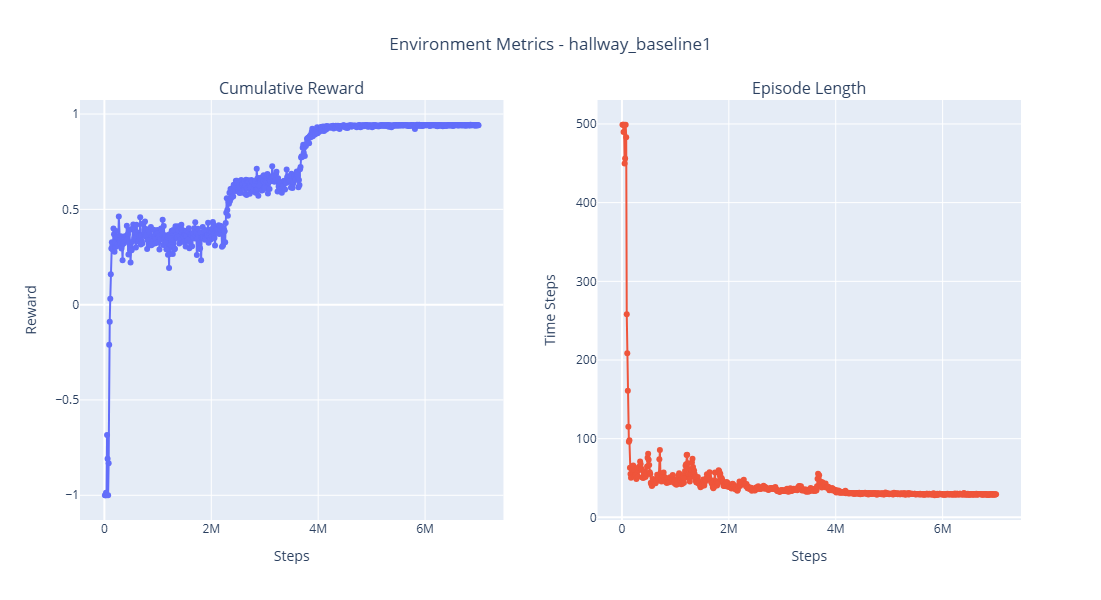


2. Loss Metrics


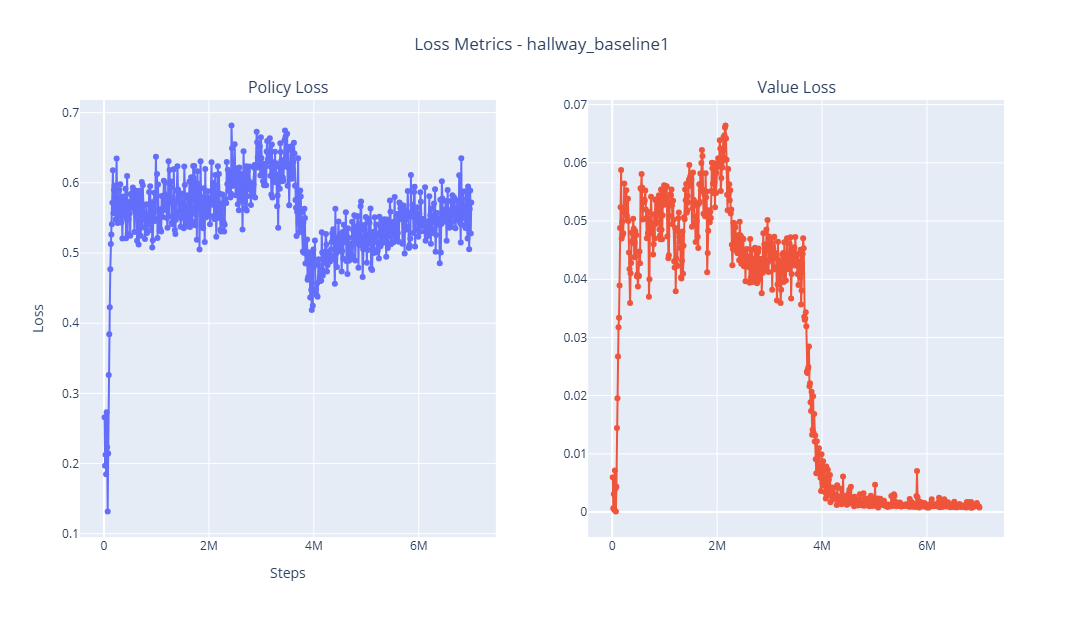


3. Policy Metrics


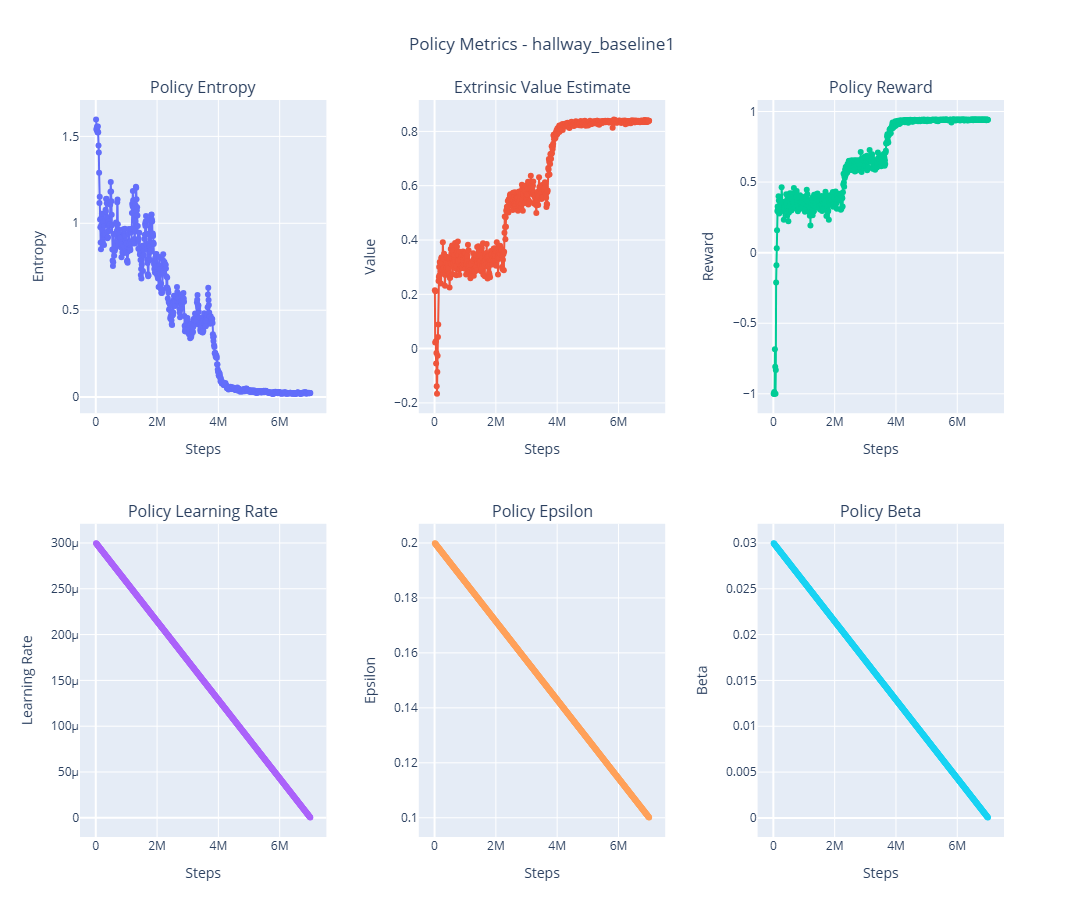


SUMMARY STATISTICS:
Final Reward: 0.94
Max Reward: 0.94
Training Steps: 7,000,000
Training Efficiency:



{'gradient_steps_per_cycle': 8.0,
 'total_updates': 24.0,
 'sample_efficiency': 42.667,
 'update_intensity': 0.023,
 'exploration_score': 5.3,
 'learning_rate': 0.0003,
 'beta': 0.03,
 'epsilon': 0.2}


Hallway Baseline Configuration



{'default_settings': None,
 'behaviors': {'Hallway': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 128,
    'buffer_size': 1024,
    'learning_rate': 0.0003,
    'beta': 0.03,
    'epsilon': 0.2,
    'lambd': 0.95,
    'num_epoch': 3,
    'shared_critic': False,
    'learning_rate_schedule': 'linear',
    'beta_schedule': 'linear',
    'epsilon_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 128,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': {'sequence_length': 64, 'memory_size': 128},
    'goal_conditioning_type': 'hyper',
    'deterministic': False},
   'reward_signals': {'extrinsic': {'gamma': 0.99,
     'strength': 1.0,
     'network_settings': {'normalize': False,
      'hidden_units': 128,
      'num_layers': 2,
      'vis_encode_type': 'simple',
      'memory': None,
      'goal_conditioning_type': 'hyper',
      'deterministic': False}}},
   'init_path': None,
   'keep_checkpoints': 5,
   'checkpoint_int


Hallway Baseline Results



{'experiment': 'hallway_baseline1',
 'final_reward': 0.941,
 'final_forecasted_reward': 0.941,
 'max_reward': 0.944,
 'forecasted_max_reward': 0.944,
 'max_reward_step': 5850000,
 'max_forecasted_reward_step': 5850000,
 'benchmark_step': 2850000,
 'convergence_step': 3980000,
 'final_entropy': 0.024,
 'mean_entropy': 0.4291,
 'entropy_std': 0.4291,
 'late_entropy_mean': 0.0856,
 'late_entropy_std': 0.1306,
 'entropy_drop': 1.574,
 'entropy_at_convergence': 0.159,
 'initial_value_loss': 0.006,
 'final_value_loss': 0.001,
 'mean_value_loss': 0.026,
 'mean_mid_value': 0.005,
 'value_loss_std': 0.0233,
 'mid_value_loss_std': 0.0097,
 'val_loss_drop': 0.005,
 'value_loss_at_convergence': 0.004,
 'initial_policy_loss': 0.266,
 'final_policy_loss': 0.572,
 'mean_policy_loss': 0.5529,
 'policy_loss_std': 0.0592,
 'policy_loss_cv': 0.1071,
 'late_policy_loss_mean': 0.5335,
 'late_policy_loss_std': 0.0392,
 'late_policy_loss_cv': 0.0735}

In [11]:
hallwaybaselinedemoconfig,hallwaybaselinedemoresults = experiment_results(mpath='/home/carolyn/results/',
                                                                          experimentname='hallway_baseline1')

print('\nHallway Baseline Configuration\n')
display(hallwaybaselinedemoconfig)
print('\nHallway Baseline Results\n')
display(hallwaybaselinedemoresults)

In [12]:
baselinereward = get_metrics(path="/home/carolyn/demos/hallway/results/",scene="/Hallway/", experiment_id='hallway_baseline',
                       metric='Environment/Cumulative Reward')

display(baselinereward.tail(50))

,step,value
142,1430000,0.382841
143,1440000,0.457845
144,1450000,0.373711
145,1460000,0.412496
146,1470000,0.387422
147,1480000,0.400528
148,1490000,0.347699
149,1500000,0.245333
150,1510000,0.363892
151,1520000,0.343164


#### Hallway Optimal Configuration (Grid Search Experiment 7)

In [13]:
hallwayoptimalconfig = getmlconfig("/home/carolyn/demos/hallway/optimal_config.yaml")

display(hallwayoptimalconfig)

{'behaviors': {'Hallway': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 256,
    'buffer_size': 25600,
    'learning_rate': 0.0005,
    'beta': 0.04,
    'epsilon': 0.35,
    'lambd': 0.95,
    'num_epoch': 5,
    'learning_rate_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 128,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': {'sequence_length': 64, 'memory_size': 128}},
   'reward_signals': {'extrinsic': {'gamma': 0.99, 'strength': 1.0}},
   'keep_checkpoints': 5,
   'max_steps': 5000000,
   'time_horizon': 64,
   'summary_freq': 10000}}}

TRAINING DASHBOARD: hallway_optimal

1. Environment Metrics


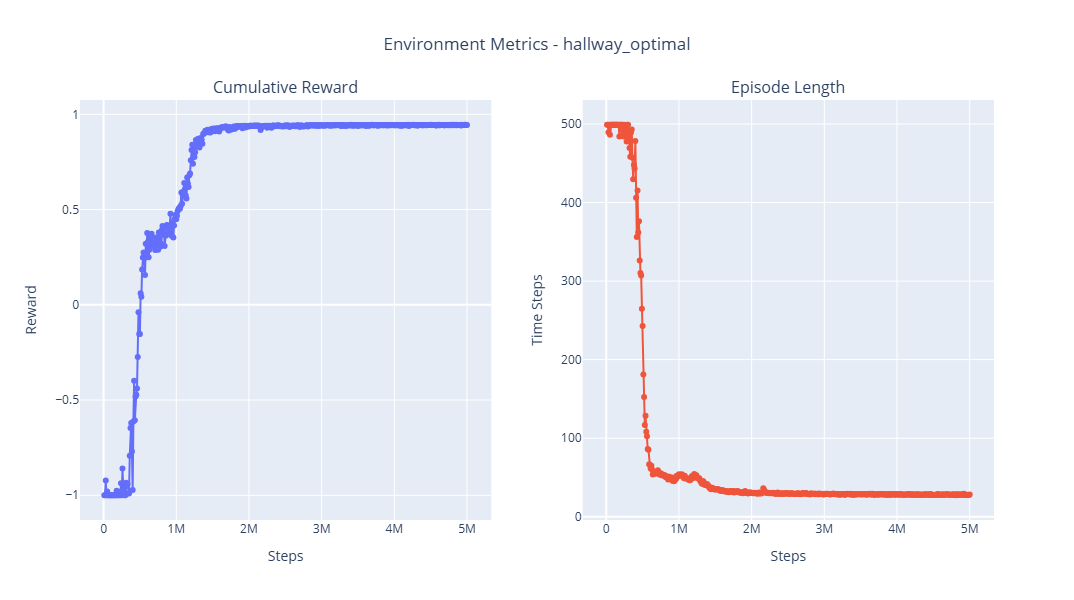


2. Loss Metrics


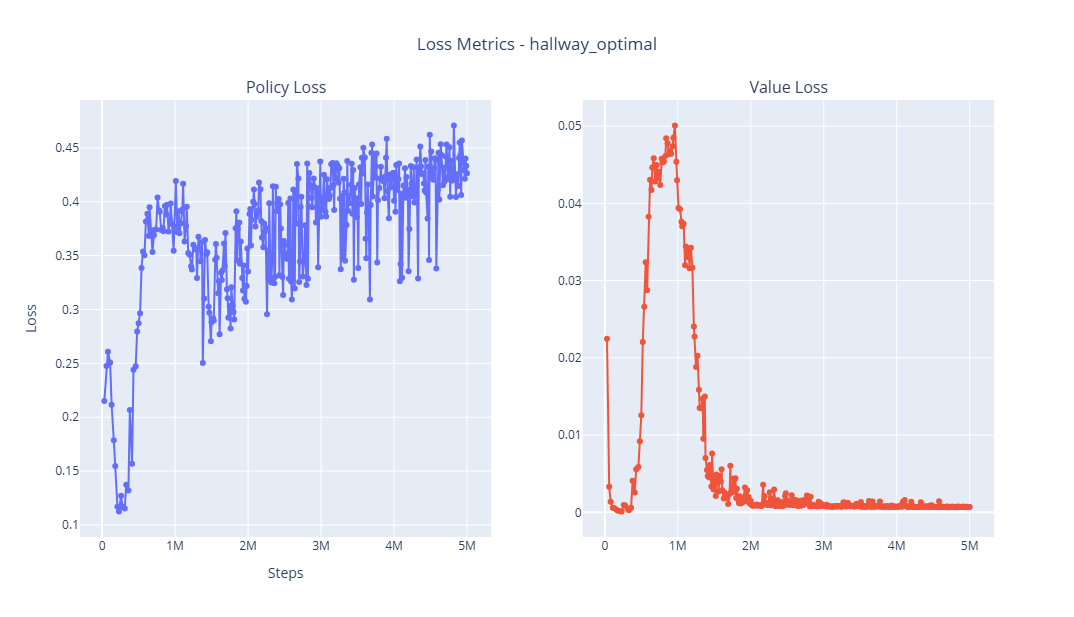


3. Policy Metrics


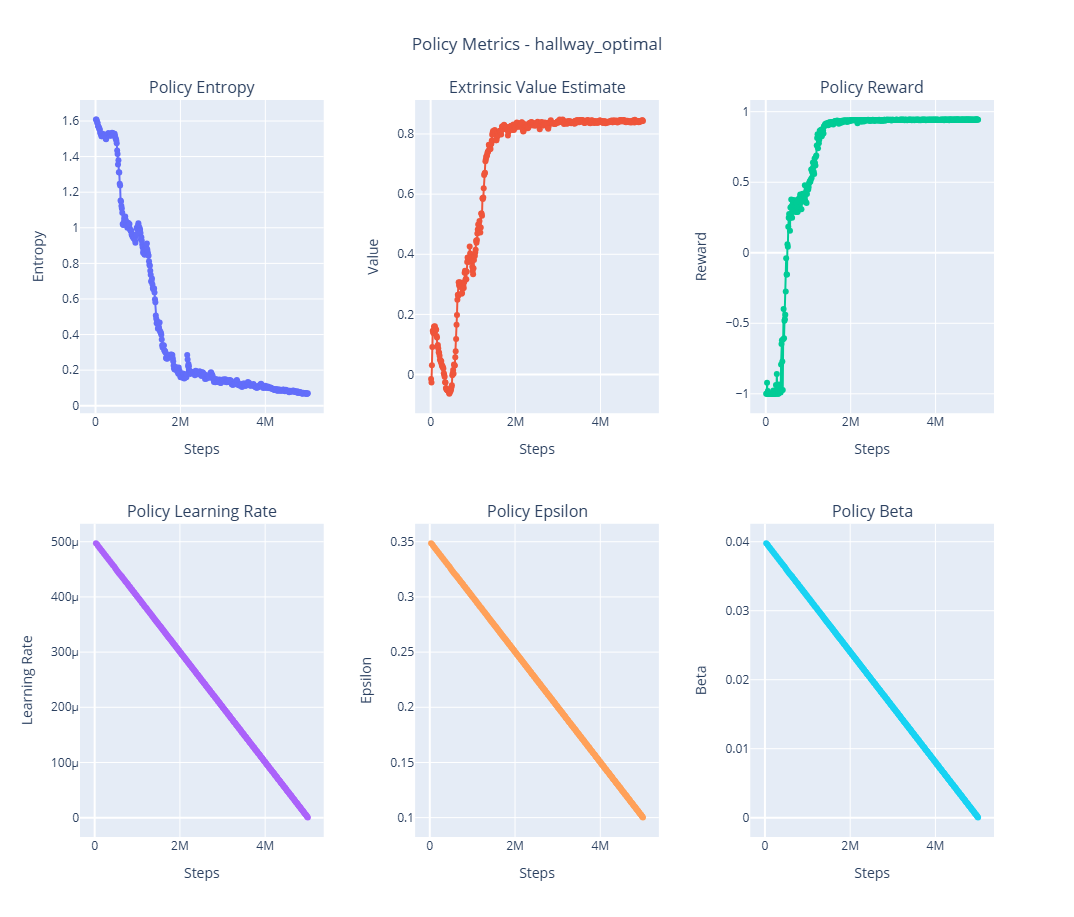


SUMMARY STATISTICS:
Final Reward: 0.94
Max Reward: 0.95
Training Steps: 5,000,000
Training Efficiency:



{'gradient_steps_per_cycle': 100.0,
 'total_updates': 500.0,
 'sample_efficiency': 51.2,
 'update_intensity': 0.02,
 'exploration_score': 8.0,
 'learning_rate': 0.0005,
 'beta': 0.04,
 'epsilon': 0.35}


Hallway Optimal Configuration



{'default_settings': None,
 'behaviors': {'Hallway': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 256,
    'buffer_size': 25600,
    'learning_rate': 0.0005,
    'beta': 0.04,
    'epsilon': 0.35,
    'lambd': 0.95,
    'num_epoch': 5,
    'shared_critic': False,
    'learning_rate_schedule': 'linear',
    'beta_schedule': 'linear',
    'epsilon_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 128,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': {'sequence_length': 64, 'memory_size': 128},
    'goal_conditioning_type': 'hyper',
    'deterministic': False},
   'reward_signals': {'extrinsic': {'gamma': 0.99,
     'strength': 1.0,
     'network_settings': {'normalize': False,
      'hidden_units': 128,
      'num_layers': 2,
      'vis_encode_type': 'simple',
      'memory': None,
      'goal_conditioning_type': 'hyper',
      'deterministic': False}}},
   'init_path': None,
   'keep_checkpoints': 5,
   'checkpoint_i


Hallway Optimal Results



{'experiment': 'hallway_optimal',
 'final_reward': 0.944,
 'final_forecasted_reward': 0.944,
 'max_reward': 0.945,
 'forecasted_max_reward': 0.945,
 'max_reward_step': 4810000,
 'max_forecasted_reward_step': 4810000,
 'benchmark_step': 1200000,
 'convergence_step': 1620000,
 'final_entropy': 0.07,
 'mean_entropy': 0.4379,
 'entropy_std': 0.4379,
 'late_entropy_mean': 0.113,
 'late_entropy_std': 0.0295,
 'entropy_drop': 1.539,
 'entropy_at_convergence': 0.312,
 'initial_value_loss': 0.022,
 'final_value_loss': 0.001,
 'mean_value_loss': 0.006,
 'mean_mid_value': 0.0008,
 'value_loss_std': 0.0126,
 'mid_value_loss_std': 0.0002,
 'val_loss_drop': 0.021,
 'value_loss_at_convergence': 0.003,
 'initial_policy_loss': 0.215,
 'final_policy_loss': 0.427,
 'mean_policy_loss': 0.3759,
 'policy_loss_std': 0.0629,
 'policy_loss_cv': 0.1673,
 'late_policy_loss_mean': 0.4126,
 'late_policy_loss_std': 0.03,
 'late_policy_loss_cv': 0.0727}

In [14]:
hallwayoptimaldemoconfig,hallwayoptimaldemoresults = experiment_results(mpath='/home/carolyn/results/',
                                                                          experimentname='hallway_optimal')

print('\nHallway Optimal Configuration\n')
display(hallwayoptimaldemoconfig)
print('\nHallway Optimal Results\n')
display(hallwayoptimaldemoresults)

#### Pyramid Demo Results

#### Baseline

In [15]:
#pyrmaid base config
display(getmlconfig("/home/carolyn/demos/pyramids/baseline_config.yaml"))

{'behaviors': {'Pyramids': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 128,
    'buffer_size': 2048,
    'learning_rate': 0.0003,
    'beta': 0.01,
    'epsilon': 0.2,
    'lambd': 0.95,
    'num_epoch': 3,
    'learning_rate_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 512,
    'num_layers': 2,
    'vis_encode_type': 'simple'},
   'reward_signals': {'extrinsic': {'gamma': 0.99, 'strength': 1.0},
    'curiosity': {'gamma': 0.99,
     'strength': 0.02,
     'network_settings': {'hidden_units': 256},
     'learning_rate': 0.0003}},
   'keep_checkpoints': 5,
   'max_steps': 6000000,
   'time_horizon': 128,
   'summary_freq': 30000}}}

TRAINING DASHBOARD: pyramids_baseline1

1. Environment Metrics


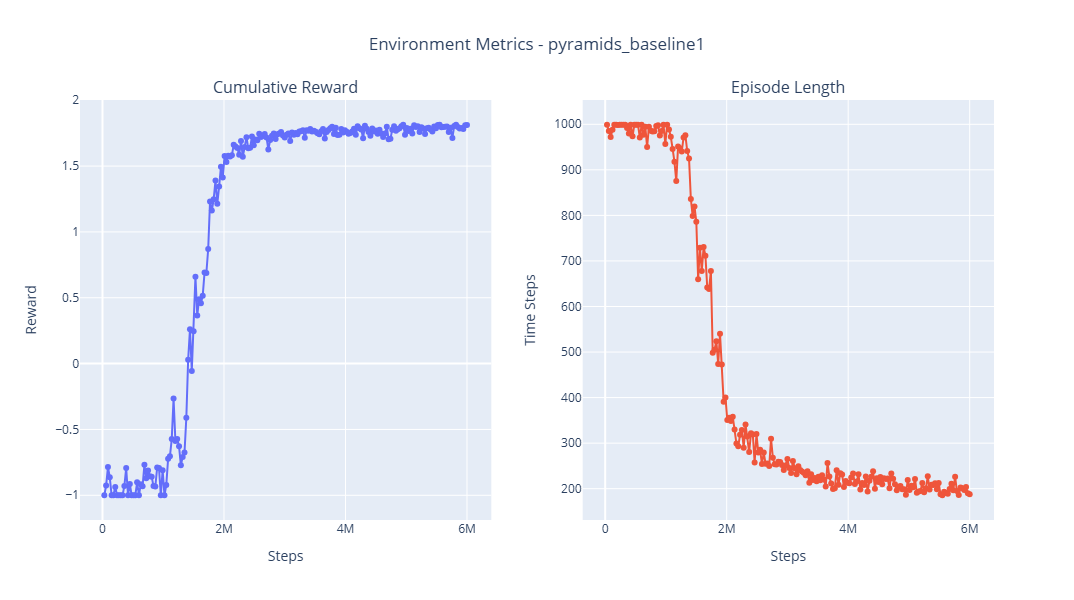


2. Loss Metrics


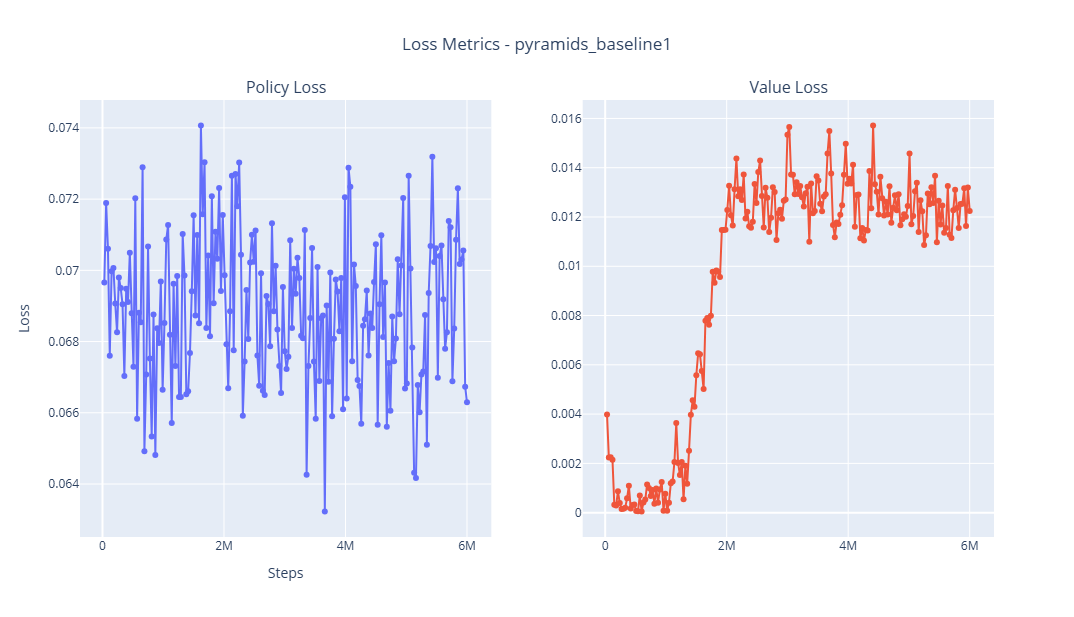


3. Policy Metrics


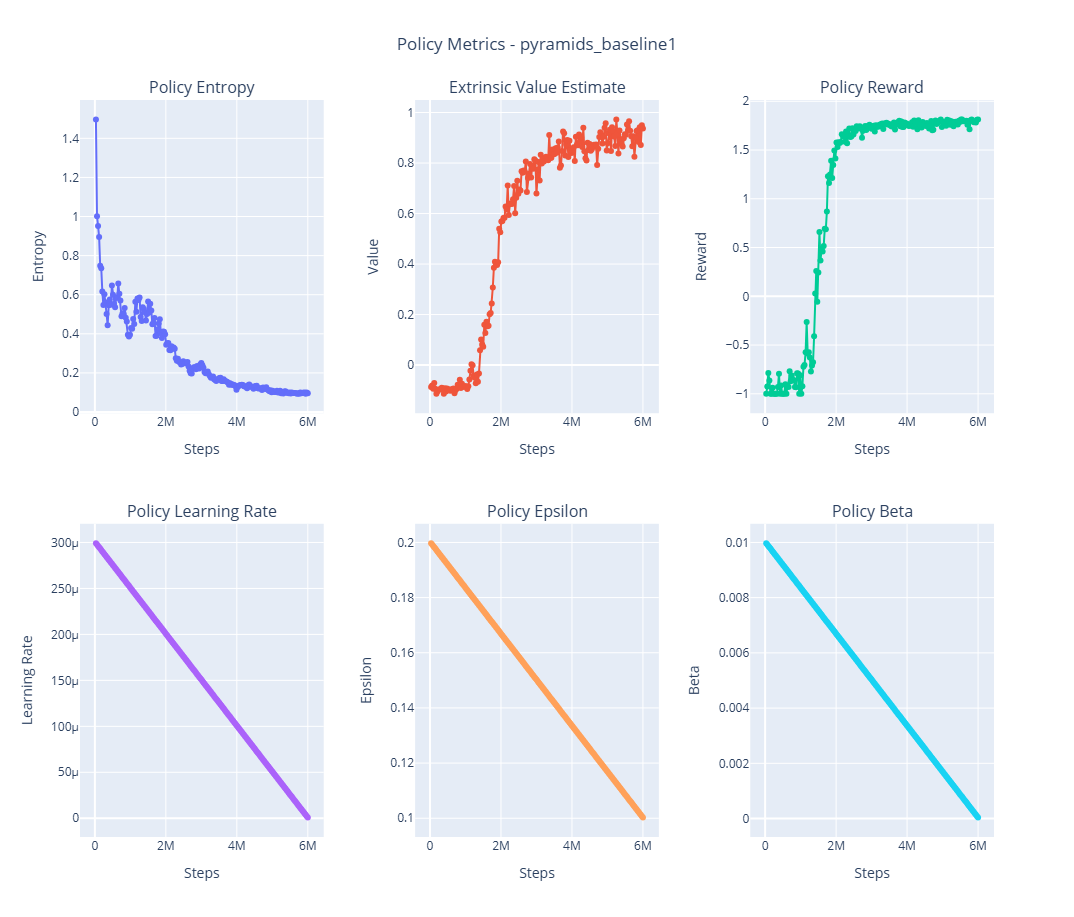


SUMMARY STATISTICS:
Final Reward: 1.81
Max Reward: 1.81
Training Steps: 6,000,000

Pyramids Baseline Configuration



{'default_settings': None,
 'behaviors': {'Pyramids': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 128,
    'buffer_size': 2048,
    'learning_rate': 0.0003,
    'beta': 0.01,
    'epsilon': 0.2,
    'lambd': 0.95,
    'num_epoch': 3,
    'shared_critic': False,
    'learning_rate_schedule': 'linear',
    'beta_schedule': 'linear',
    'epsilon_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 512,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': None,
    'goal_conditioning_type': 'hyper',
    'deterministic': False},
   'reward_signals': {'extrinsic': {'gamma': 0.99,
     'strength': 1.0,
     'network_settings': {'normalize': False,
      'hidden_units': 128,
      'num_layers': 2,
      'vis_encode_type': 'simple',
      'memory': None,
      'goal_conditioning_type': 'hyper',
      'deterministic': False}},
    'curiosity': {'gamma': 0.99,
     'strength': 0.02,
     'network_settings': {'normalize': False,
   


Pyramids Baseline Results



{'experiment': 'pyramids_baseline1',
 'final_reward': 1.812,
 'final_forecasted_reward': 1.812,
 'max_reward': 1.814,
 'forecasted_max_reward': 1.814,
 'max_reward_step': 5820000,
 'max_forecasted_reward_step': 5820000,
 'convergence_step': 2580000,
 'final_entropy': 0.097,
 'mean_entropy': 0.2906,
 'entropy_std': 0.2906,
 'late_entropy_mean': 0.131,
 'late_entropy_std': 0.0333,
 'entropy_drop': 1.4,
 'entropy_at_convergence': 0.254,
 'initial_value_loss': 0.004,
 'final_value_loss': 0.012,
 'mean_value_loss': 0.009,
 'mean_mid_value': 0.0126,
 'value_loss_std': 0.005,
 'mid_value_loss_std': 0.001,
 'val_loss_drop': -0.008,
 'value_loss_at_convergence': 0.004,
 'initial_policy_loss': 0.07,
 'final_policy_loss': 0.066,
 'mean_policy_loss': 0.0689,
 'policy_loss_std': 0.0021,
 'policy_loss_cv': 0.0305,
 'late_policy_loss_mean': 0.0686,
 'late_policy_loss_std': 0.0021,
 'late_policy_loss_cv': 0.0306}

In [16]:
pyramidbaselinedemoconfig,pyramidbaselinedemoresults = pyramids_results(mpath='/home/carolyn/results/',
                                                                          experimentname='pyramids_baseline1')

print('\nPyramids Baseline Configuration\n')
display(pyramidbaselinedemoconfig)
print('\nPyramids Baseline Results\n')
display(pyramidbaselinedemoresults)

#### Optimal Configuration from PyramidsTransferExp7

In [17]:
#pyrmaid optimal config
display(getmlconfig("/home/carolyn/demos/pyramids/optimal_config.yaml"))

{'behaviors': {'Pyramids': {'hyperparameters': {'batch_size': 256,
    'beta': 0.01,
    'buffer_size': 5120,
    'epsilon': 0.2,
    'lambd': 0.95,
    'learning_rate': 0.0004,
    'learning_rate_schedule': 'linear',
    'num_epoch': 4},
   'keep_checkpoints': 5,
   'max_steps': 7000000,
   'network_settings': {'hidden_units': 512,
    'normalize': False,
    'num_layers': 2,
    'vis_encode_type': 'simple'},
   'reward_signals': {'curiosity': {'gamma': 0.99,
     'learning_rate': 0.0005,
     'network_settings': {'hidden_units': 256},
     'strength': 0.02},
    'extrinsic': {'gamma': 0.99, 'strength': 1.0}},
   'summary_freq': 30000,
   'time_horizon': 128,
   'trainer_type': 'ppo'}}}

TRAINING DASHBOARD: pyramids_optimal

1. Environment Metrics


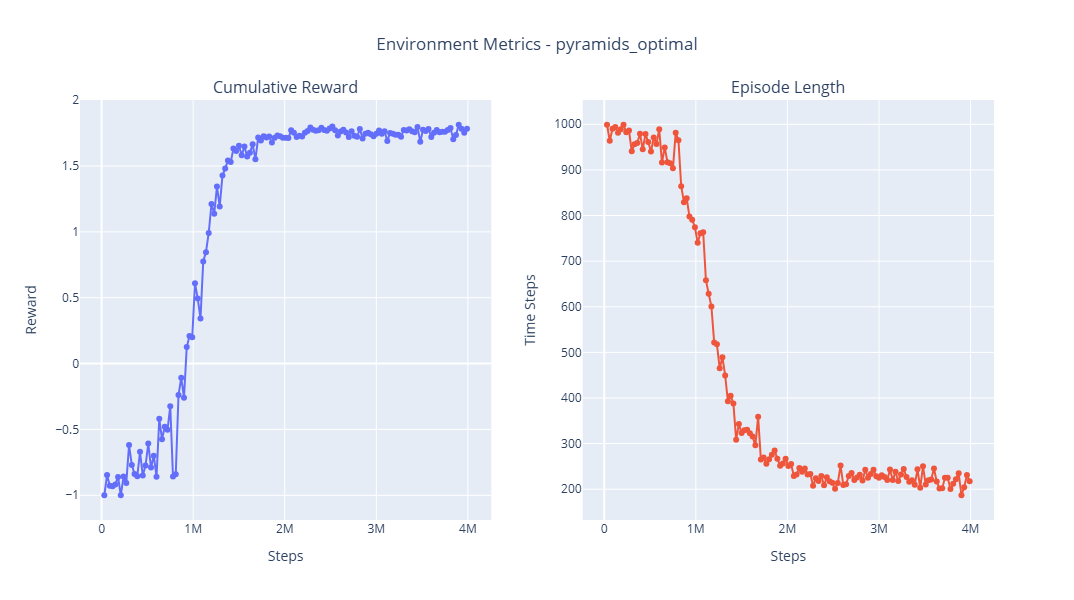


2. Loss Metrics


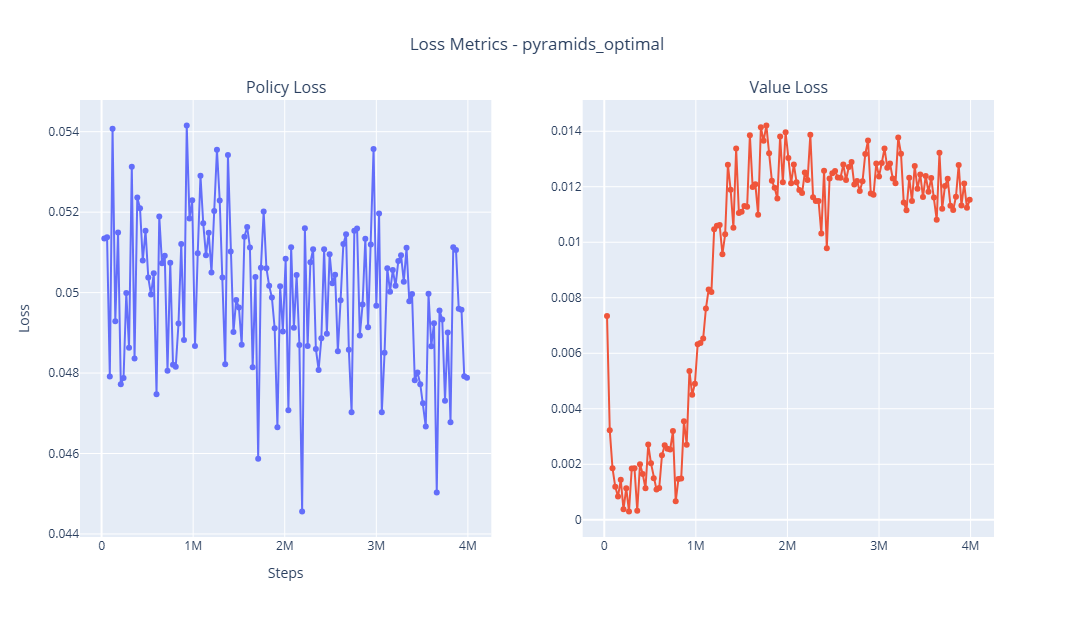


3. Policy Metrics



SUMMARY STATISTICS:
Final Reward: 1.78
Max Reward: 1.81
Training Steps: 3,990,000

Pyramids Optimal Configuration



{'default_settings': None,
 'behaviors': {'Pyramids': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 256,
    'buffer_size': 5120,
    'learning_rate': 0.0004,
    'beta': 0.01,
    'epsilon': 0.2,
    'lambd': 0.95,
    'num_epoch': 4,
    'shared_critic': False,
    'learning_rate_schedule': 'linear',
    'beta_schedule': 'linear',
    'epsilon_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 512,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': None,
    'goal_conditioning_type': 'hyper',
    'deterministic': False},
   'reward_signals': {'curiosity': {'gamma': 0.99,
     'strength': 0.02,
     'network_settings': {'normalize': False,
      'hidden_units': 256,
      'num_layers': 2,
      'vis_encode_type': 'simple',
      'memory': None,
      'goal_conditioning_type': 'hyper',
      'deterministic': False},
     'learning_rate': 0.0005,
     'encoding_size': None},
    'extrinsic': {'gamma': 0.99,
     'strengt


Pyramids Optimal Results



{'experiment': 'pyramids_optimal',
 'final_reward': 1.782,
 'final_forecasted_reward': 1.782,
 'max_reward': 1.813,
 'forecasted_max_reward': 1.813,
 'max_reward_step': 3900000,
 'max_forecasted_reward_step': 3900000,
 'convergence_step': 2070000,
 'final_entropy': 0.175,
 'mean_entropy': 0.4138,
 'entropy_std': 0.4138,
 'late_entropy_mean': 0.2448,
 'late_entropy_std': 0.034,
 'entropy_drop': 1.343,
 'entropy_at_convergence': 0.288,
 'initial_value_loss': 0.007,
 'final_value_loss': 0.012,
 'mean_value_loss': 0.009,
 'mean_mid_value': 0.0122,
 'value_loss_std': 0.0044,
 'mid_value_loss_std': 0.0008,
 'val_loss_drop': -0.005,
 'value_loss_at_convergence': 0.007,
 'initial_policy_loss': 0.051,
 'final_policy_loss': 0.048,
 'mean_policy_loss': 0.0499,
 'policy_loss_std': 0.0018,
 'policy_loss_cv': 0.0361,
 'late_policy_loss_mean': 0.0495,
 'late_policy_loss_std': 0.0017,
 'late_policy_loss_cv': 0.0343}

In [30]:
pyramidoptimaldemoconfig,pyramidoptimaldemoresults = pyramids_results(mpath="/home/carolyn/results/",
                                                                          experimentname='pyramids_optimal')

print('\nPyramids Optimal Configuration\n')
display(pyramidoptimaldemoconfig)
print('\nPyramids Optimal Results\n')
display(pyramidoptimaldemoresults)

### Key PPO Hyperparameters: Learning Rate, Buffer Size, Epochs 

Proximal Policy Optimisation (PPO) is the industry standard for reinforcement learning in Unity because it is highly stable and effective. The tune PPO, you must understand the four most ciriticaly hyperparamters that control the balance between collecting experience and optimizing the policy.

##### __Critical PPO Hyperparamters__

* __learning_rate:__ The step size for gradient descent. How aggressively the model updates it weights.
    * Typical Range: 1.0e-5 to 3.0e-4
    * Expert Tip: Start high (3e-4) and reduce if reward oscilattes too wildly. Too high -> divergence | Too low -> slow learning
* __clip_epsilon:__ The size of the 'trust region.'. Defines how much the policy probability ratio can deviate.
    * The default 0.2 is generaly safe. For highly non-linear challenging tasks, you can increase it slightly to 0.3
    * Expert Tip: When it is too small, learning stalls or becomes extremely slow. When it is too large, policy updates become too aggressive  
* __buffer_size:__ Total number of steps of experience collected before the network performs an optimization pass.
    * Typical Range: 2,048 to 2,048,000
    * Expert Tip: Should be large enough to capture one full, succesful episode's worth of data. Use larger values for complex tasks.
* __batch_size:__ The number llof experiences used in one stochastic gradient descent step.
    * Typical Range: 512 to 4,096
    * Expert Tip: Should be a fraction of __buffer_size__. Too small -> high variance in updates.
* __num_epoch:__ The number of times the network iterates over the collected __buffer_size__ data.
    * Typical Range: 3 to 10
    * Expert Tip: Higher epochs ensure better use of the collected data,but can lead to policy updates being too far from the previous state (violating PPO 'proximal' contraint)
* __gamma:__ The __discount factor__ (long term focus).
    * Typical Range: 0.85 to 0.995
    * Expert Tip: Use low values for short tasks (0.9). Use high values for long-term planning/complex tasks (0.99-0.995)
* __lambd:__ The __GAE Parameter__. Controls the balance of bias/variance in the advantage estimate
    * Stick to the default 0.95. Reduce slightly if training is highly unstable.
 
#### The Training Loop Cycle: Understanding the rationship between buffer_size, batch_size, & num_epochs is key to performance

1. __Experience Collection:__ The Agent runs in Unity until the total number of steps equals the __buffer_size__.
2. __Optimization:__ The Agent pauses, and the Python network takes the collected experiences
3. __Gradient Steps:__ The entire buffer is broken into chunks of __batch_size__.
4. __Update:__ The network runs optimization for __num_epoch__ passes over the buffer, performing (__buffer_size__/__batch_size__) * __num_epoch__ total updates

### Demo Code to Generate Config Combinations using Grid Search

In [55]:
import itertools

#define the parameter grid

grid = {
     'beta': [0.03,0.035,0.04],
     'learning_rate': [0.0003,0.0004,0.0005],
     'epsilon': [0.35],
     'batch_size': [256],
     'buffer_size': [25600],
     'num_epochs': [5],
     'max_steps':[5000000]
     
 }

keys = list(grid.keys())
values = list(grid.values())

#get config combos

hallway_param_grid = []
experiment = 1
for combo in itertools.product(*values):
    params = dict(zip(keys,combo))
    params['experiment'] = experiment
    hallway_param_grid.append(params)
    experiment +=1

In [56]:
def scene_config(beta,learning_rate,espilon, batch_size,buffer, epochs,max_steps):

    grid = {
        'beta': beta,
        'learning_rate': learning_rate,
        'epsilon': epsilon,
        'batch_size': batch_size,
        'buffer_size': buffer,
        'num_epochs': epochs,
        'max_steps': max_steps
    }

    keys = list(grid.keys())
    values = list(grid.values())

    hallway_param_grid = []

    experiment = 1

    for combo in itertools.product(*values):
        params = dict(zip(keys,combo))
        params['experiment'] = experiment
        hallway_param_grid.append(params)
        experiment +=1


    return hallway_param_grid


In [57]:
num_of_experiments = len(hallway_param_grid)
print(f'Total Number of Experiments to Run: {num_of_experiments} \n')
display(hallway_param_grid)

Total Number of Experiments to Run: 9 



[{'beta': 0.03,
  'learning_rate': 0.0003,
  'epsilon': 0.35,
  'batch_size': 256,
  'buffer_size': 25600,
  'num_epochs': 5,
  'max_steps': 5000000,
  'experiment': 1},
 {'beta': 0.03,
  'learning_rate': 0.0004,
  'epsilon': 0.35,
  'batch_size': 256,
  'buffer_size': 25600,
  'num_epochs': 5,
  'max_steps': 5000000,
  'experiment': 2},
 {'beta': 0.03,
  'learning_rate': 0.0005,
  'epsilon': 0.35,
  'batch_size': 256,
  'buffer_size': 25600,
  'num_epochs': 5,
  'max_steps': 5000000,
  'experiment': 3},
 {'beta': 0.035,
  'learning_rate': 0.0003,
  'epsilon': 0.35,
  'batch_size': 256,
  'buffer_size': 25600,
  'num_epochs': 5,
  'max_steps': 5000000,
  'experiment': 4},
 {'beta': 0.035,
  'learning_rate': 0.0004,
  'epsilon': 0.35,
  'batch_size': 256,
  'buffer_size': 25600,
  'num_epochs': 5,
  'max_steps': 5000000,
  'experiment': 5},
 {'beta': 0.035,
  'learning_rate': 0.0005,
  'epsilon': 0.35,
  'batch_size': 256,
  'buffer_size': 25600,
  'num_epochs': 5,
  'max_steps': 500000

In [39]:
hallway_path = "/home/carolyn/demos/hallway/baseline_config.yaml"
hallwayconfig = getmlconfig("/home/carolyn/demos/hallway/baseline_config.yaml")

In [58]:
hallway_configs = []

for combo in hallway_param_grid:
    configupdate = update_config(hallwayconfig, scene='Hallway', hyperparameter='beta', data=combo['beta'])
    configupdate = update_config(hallwayconfig, scene='Hallway', hyperparameter='learning_rate', data=combo['learning_rate'])
    configupdate = update_config(hallwayconfig, scene='Hallway', hyperparameter='batch_size', data=combo['batch_size'])
    configupdate = update_config(hallwayconfig, scene='Hallway', hyperparameter='buffer_size', data=combo['buffer_size'])
    configupdate = update_config(hallwayconfig, scene='Hallway', hyperparameter='epsilon', data=combo['epsilon'])
    configupdate = update_config(hallwayconfig, scene='Hallway', hyperparameter='num_epoch', data=combo['num_epochs'])
    configupdate['behaviors']['Hallway']['max_steps'] = 5000000
    hallway_configs.append(configupdate)

In [59]:
display(hallway_configs[0])

{'behaviors': {'Hallway': {'trainer_type': 'ppo',
   'hyperparameters': {'batch_size': 256,
    'buffer_size': 25600,
    'learning_rate': 0.0005,
    'beta': 0.04,
    'epsilon': 0.35,
    'lambd': 0.95,
    'num_epoch': 5,
    'learning_rate_schedule': 'linear'},
   'network_settings': {'normalize': False,
    'hidden_units': 128,
    'num_layers': 2,
    'vis_encode_type': 'simple',
    'memory': {'sequence_length': 64, 'memory_size': 128}},
   'reward_signals': {'extrinsic': {'gamma': 0.99, 'strength': 1.0}},
   'keep_checkpoints': 5,
   'max_steps': 5000000,
   'time_horizon': 64,
   'summary_freq': 10000}}}

In [60]:
# create a new yaml config for each 
for i, config in enumerate(hallway_configs, start=1):
    with open(f'hallway_config_{i}.yaml', 'w') as f:
        yaml.dump(config, f)